In [30]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
from manifold_encoder_decoder import s1_direct_product_decoder, s1_direct_product_generator, geometry_util

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Generate some ring data

In [39]:
encoder, decoder = s1_direct_product_generator.train(1, 12, device, n_training_iterations=3000)
angles = np.arange(start=0, stop=2 * np.pi, step=0.01)
with torch.no_grad():
    points = geometry_util.torch_angles_to_ring(torch.tensor(angles, dtype=torch.get_default_dtype()).to(device))
    points = torch.unsqueeze(points, -2)
    ring_embedded_points = encoder(points)
ring_embedded_points = ring_embedded_points.cpu().numpy()

/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 0.5550218820571899, distance cost: 0.009940526448190212
iteration: 4, decoding loss: 0.4755215346813202, distance cost: 0.06182458996772766
iteration: 5, decoding loss: 0.4021611213684082, distance cost: 0.07705876231193542
iteration: 15, decoding loss: 0.27209028601646423, distance cost: 0.14420844614505768
iteration: 16, decoding loss: 0.21606691181659698, distance cost: 0.13240894675254822
iteration: 17, decoding loss: 0.20091013610363007, distance cost: 0.13842038810253143
iteration: 18, decoding loss: 0.17380349338054657, distance cost: 0.10409928113222122
iteration: 30, decoding loss: 0.1927127093076706, distance cost: 0.07144524157047272
iteration: 31, decoding loss: 0.16289962828159332, distance cost: 0.07221757620573044
iteration: 32, decoding loss: 0.13637028634548187, distance cost: 0.0710974782705307
iteration: 33, decoding loss: 0.13186870515346527, distance cost: 0.06302493065595627
iteration: 34, decoding loss: 0.12255597859621048, distance c

In [40]:
sample_indicies = np.random.choice(np.shape(ring_embedded_points)[0], 100)
test_ring_data = ring_embedded_points[sample_indicies, :]
test_ring_phases = angles[sample_indicies]

Form a simple torus as the product of two rings

In [42]:
possible_samples = np.arange(start=0, stop=np.shape(test_ring_data)[0], step=1)
possible_pairs = []
for sample_1 in possible_samples:
    for sample_2 in possible_samples:
        possible_pairs.append([sample_1, sample_2])

possible_pairs = np.array(possible_pairs)
n_samples = 1000
samples = np.random.choice(len(possible_pairs), n_samples)
indicies = possible_pairs[samples, :]

data_1 = test_ring_data[indicies[:, 0], :]
phases_1 = test_ring_phases[indicies[:, 0]]

data_2 = test_ring_data[indicies[:, 1], :]
phases_2 = test_ring_phases[indicies[:, 1]]

product_torus_data = np.concatenate([data_1, data_2], axis=1)
product_torus_data = product_torus_data/np.mean(np.abs(product_torus_data))
product_torus_phases = np.stack([phases_1, phases_2], axis=-1)

Decode the product torus

In [48]:
encoder, decoder = s1_direct_product_decoder.train(data=product_torus_data, manifold_dim=2, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1)

iteration: 0, decoding loss: 1.4031552076339722, distance cost: 0.005262357648462057, order reduction: 0.01564832590520382
iteration: 2, decoding loss: 0.7245487570762634, distance cost: 0.01874873787164688, order reduction: 0.011253944598138332
iteration: 3, decoding loss: 0.523115873336792, distance cost: 0.01487995870411396, order reduction: 0.08151622861623764
iteration: 4, decoding loss: 0.4769239127635956, distance cost: 0.00841487105935812, order reduction: 0.04448540881276131
iteration: 6, decoding loss: 0.44578441977500916, distance cost: 0.0108592314645648, order reduction: 0.0458587221801281
iteration: 7, decoding loss: 0.36080312728881836, distance cost: 0.004157400224357843, order reduction: 0.08117220550775528
iteration: 12, decoding loss: 0.35279232263565063, distance cost: 0.01036866195499897, order reduction: 0.03873365372419357
iteration: 13, decoding loss: 0.35167887806892395, distance cost: 0.012328209355473518, order reduction: 0.080825075507164
iteration: 14, deco

In [56]:
with torch.no_grad():
    product_predicted_phases = decoder(torch.tensor(product_torus_data, dtype=torch.get_default_dtype()).to(device))[1].cpu().numpy()

In [45]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[1])

In [59]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_axes):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    if np.abs(refd_test_phases[1,1] - refd_true_phases[1, 0]) < np.abs(refd_test_phases[1,1] - refd_true_phases[1, 1]):
        refd_test_phases = np.stack([refd_test_phases[:, 1], refd_test_phases[:, 0]], axis=-1)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_axes[0].scatter(refd_true_phases[:, 0], refd_test_phases[:, 0])
    plot_axes[0].plot(line, line, color="black", linestyle="--", label="y=x")
    plot_axes[1].scatter(refd_true_phases[:, 1], refd_test_phases[:, 1])
    plot_axes[1].plot(line, line, color="black", linestyle="--", label="y=x")
    plot_axes[0].set_xlabel("True Phase")
    plot_axes[0].set_title("Phase 1")
    plot_axes[1].set_xlabel("True Phase")
    plot_axes[1].set_title("Phase 2")
    plot_axes[0].set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases

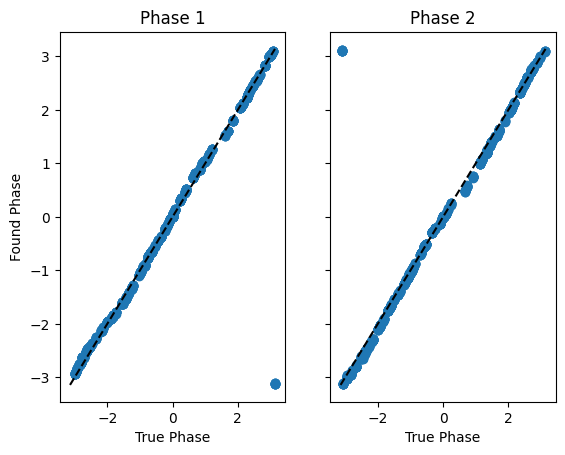

In [60]:
fig, axs = plt.subplots(ncols=2, sharey=True)
referenced_product_predicted_phases, referenced_product_true_phases = compare_to_ground_truth(product_predicted_phases, product_torus_phases, axs)

Make a torus directly using the generative model

In [88]:
encoder, decoder = s1_direct_product_generator.train(2, 24, device, n_training_iterations=5000)

torus_phases = np.random.uniform(0, 2 * np.pi, (1000, 2))
with torch.no_grad():
    points = geometry_util.torch_angles_to_ring(torch.tensor(torus_phases, dtype=torch.get_default_dtype()).to(device))
    torus_embedded_points = encoder(points)
torus_embedded_points = torus_embedded_points.cpu().numpy()

iteration: 0, decoding loss: 0.9608908891677856, distance cost: 0.008387724868953228
iteration: 1, decoding loss: 0.6629870533943176, distance cost: 0.013581790030002594
iteration: 2, decoding loss: 0.38375261425971985, distance cost: 0.021053431555628777
iteration: 3, decoding loss: 0.36084163188934326, distance cost: 0.03147720918059349
iteration: 4, decoding loss: 0.3406628370285034, distance cost: 0.04097241163253784
iteration: 12, decoding loss: 0.29289332032203674, distance cost: 0.08331833779811859
iteration: 13, decoding loss: 0.20493197441101074, distance cost: 0.0779484212398529
iteration: 100, decoding loss: 0.22534659504890442, distance cost: 0.049325186759233475
iteration: 101, decoding loss: 0.21895423531532288, distance cost: 0.05398978292942047
iteration: 107, decoding loss: 0.20813660323619843, distance cost: 0.05600898712873459
iteration: 153, decoding loss: 0.2021750658750534, distance cost: 0.055654190480709076
iteration: 154, decoding loss: 0.19125905632972717, dis

Decode the generated torus

In [89]:
normed_torus_embedded_points = torus_embedded_points/np.mean(np.abs(torus_embedded_points))

In [90]:
encoder, decoder = s1_direct_product_decoder.train(data=normed_torus_embedded_points, manifold_dim=2, device=device,
                                                   n_training_iterations=3000, decoder_weight=10, order_red_weight=0.1)


iteration: 0, decoding loss: 1.521405577659607, distance cost: 0.008925306610763073, order reduction: 0.01068280078470707
iteration: 1, decoding loss: 1.4819611310958862, distance cost: 0.024915555492043495, order reduction: 0.009225278161466122
iteration: 2, decoding loss: 0.8463647365570068, distance cost: 0.012319426983594894, order reduction: 0.0068453773856163025
iteration: 3, decoding loss: 0.7290579080581665, distance cost: 0.008748804219067097, order reduction: 0.00777954887598753
iteration: 4, decoding loss: 0.655819833278656, distance cost: 0.014814715832471848, order reduction: 0.007789605762809515
iteration: 5, decoding loss: 0.5872709155082703, distance cost: 0.014955900609493256, order reduction: 0.007696028333157301
iteration: 6, decoding loss: 0.5755332708358765, distance cost: 0.02237280085682869, order reduction: 0.008727794513106346
iteration: 7, decoding loss: 0.516537606716156, distance cost: 0.01838044449687004, order reduction: 0.008984765969216824
iteration: 8, 

In [91]:
with torch.no_grad():
    gen_predicted_phases = decoder(torch.tensor(normed_torus_embedded_points, dtype=torch.get_default_dtype()).to(device))[1].cpu().numpy()

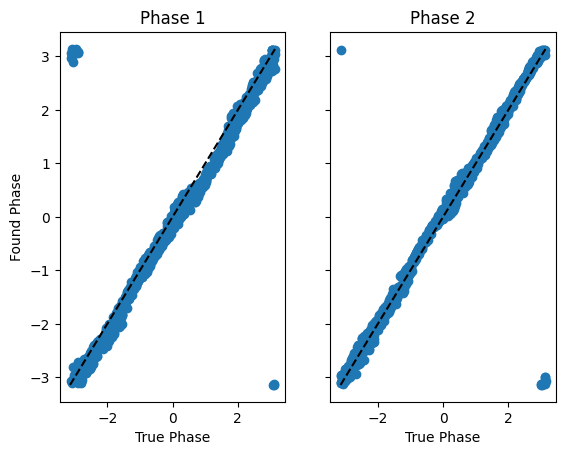

In [94]:
fig, axs = plt.subplots(ncols=2, sharey=True)
referenced_gen_predicted_phases, referenced_gen_true_phases = compare_to_ground_truth(gen_predicted_phases, torus_phases, axs)
